## Zadanie - klasyczna detekcja obiektów

Dany jest obraz wzorcowy `calib` przedstawiający leki w organizerze.
Celem zadania będzie zaprojektowanie algorytmu detekcji i analizy obiektów,
pozwalającego na zliczenie leków poszczególnych gatunków z podziałem na komórki organizera.

Występuje 7 klas obiektów; od lewej w górnym rzędzie
* `line`\*: czerwono-białe kapsułki
* `keto`: niebieskie tabletki
* `carbon`: duże czarne kapsułki
* `probio`: duże białe kapsułki
* `biox`: małe białe tabletki
* `espu`: małe żółte kapsułki
* `dexi`\*: niebiesko-szare kapsułki (w dolnym rzędzie)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from typing import List

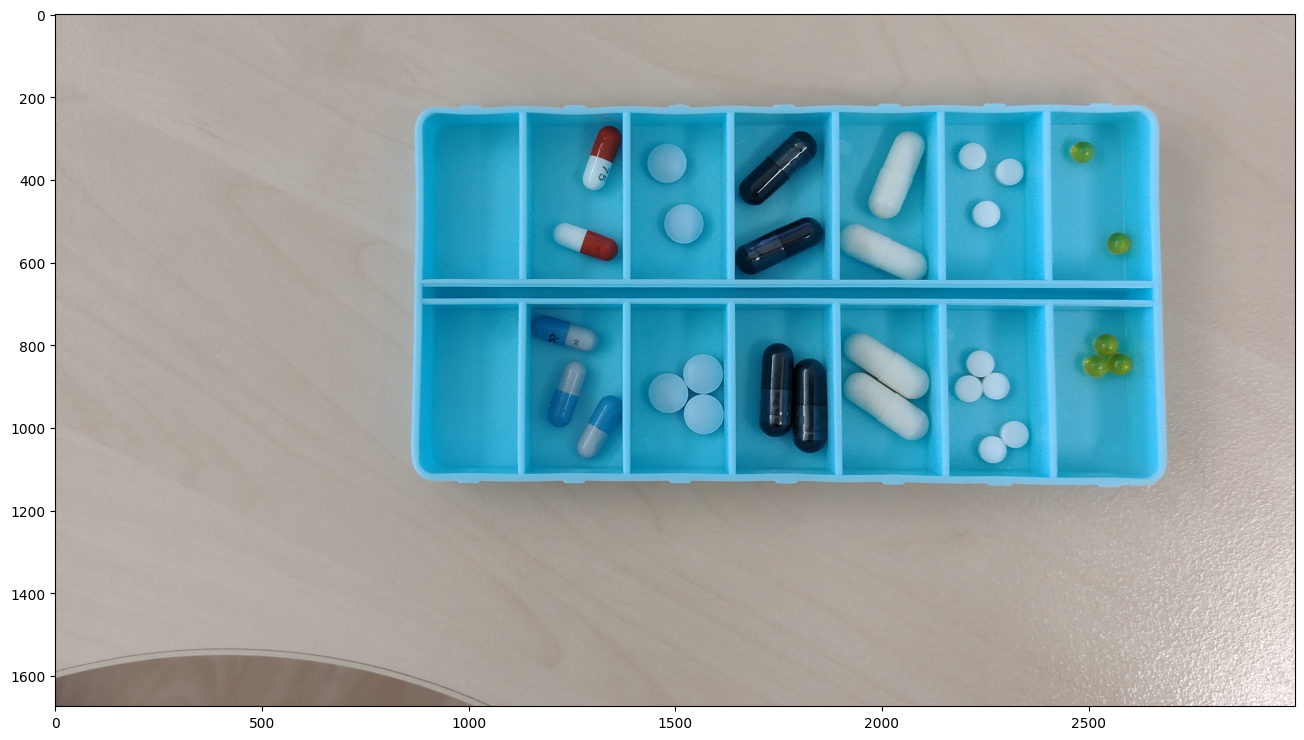

In [2]:
calib = cv2.imread('Data/calib.png')#cv2.imread('Data/calib.png')
plt.subplots(1, 1, figsize=(16,9))[1].imshow(calib[..., ::-1]);

### Zadanie 1
Wykorzystując narzędzia poznane na poprzednich zajęciach (konwersja przestrzeni barw, detekcja krawędzi, binaryzacja, etc.) oraz [`cv2.findContours`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0), zaproponuj algorytm detekcji obiektów (funkcja `detect_objects`).
Poprawnie działający algorytm powinien zwracać listę konturów lub bounding boksów reprezentujących poszczególne obiekty
(czy nawet dowolnych obiektów zawierających jedno i drugie).

W zależności od przyjętego podejścia, doimplementuj metodę `display_objects`, by wyświetlić rezultaty.

Podpowiedzi:
* zacznij od górnego wiersza, z pominięciem dwukolorowych kapsułek
* w drugiej kolejności podejmij problem stykających się obiektów
* dwukolorowe kapsułki są "dla ambitnych"

### Rozwiązanie

In [8]:
def get_contours(image, contours_type, min_area=-1, max_area=-1):
    contours, hierarchy = cv2.findContours(image, contours_type, method=cv2.CHAIN_APPROX_NONE)
    if min_area > 0:
        contours = [c for c in contours if cv2.contourArea(c) >= min_area] 
    if max_area > 0:
        contours = [c for c in contours if max_area >= cv2.contourArea(c)] 
        
    return contours

def get_image_for_contours_finding(img, contours_transformation):
    img = contours_transformation['gray'](img)
    img = contours_transformation['threshold'](img)
    return img

In [4]:
def plot_img(img, title, with_contours=False, contours_transformation=None, contours_args=None):
    if with_contours:
        fig, ax = plt.subplots(1, 2, figsize=(14,4))
        ax[0].imshow(img, cmap='gray');
        
        img = contours_transformation['gray'](img)
        img = contours_transformation['threshold'](img)
        contours = get_contours(img, **contours_args)
        contours_img = np.zeros_like(img)
        cv2.drawContours(contours_img, contours, -1, (255, 255, 0), 3)

        ax[1].imshow(contours_img, cmap='gray');
        
        plt.title(title)
        ax[1].set_title(f'Contours. Contours number: {len(contours)}')
        #plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(10, 4))
        plt.imshow(img, cmap='gray');
        plt.title(title)
        #plt.tight_layout()
        plt.show()

Pierwsze zastosowane podejście opierało się o 

In [5]:
def morphology(img):
    eroded = cv2.erode(img, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE)
    opened = cv2.dilate(eroded, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE)
    return opened

In [10]:
default_contours_args = {
    'contours_type': cv2.RETR_EXTERNAL,
    'min_area': -1,
    'max_area': -1
}

def detect_objects_configurable(image:np.ndarray,
                                plot_with_contours=False, 
                                contours_transformation=None,
                                contours_args=None,
                                **kwargs):
    plot_img(image, title='Basic', 
         with_contours=plot_with_contours, 
         contours_transformation=contours_transformation, 
         contours_args=contours_args)
    
    for name, transformation in kwargs.items():
        if name.startswith('trans'):
            image = transformation(image)
            plot_img(image, title=name, 
                     with_contours=plot_with_contours, 
                     contours_transformation=contours_transformation, 
                     contours_args=contours_args)
    
    image = get_image_for_contours_finding(image, contours_transformation)
    contours = get_contours(image, **contours_args)
    print('Liczba konturow: ', len(contours))
    display = np.zeros_like(image)
    cv2.drawContours(display, contours, -1, (255, 255, 0), 3)
    plot_img(display, 'Kontury')
    
    return contours

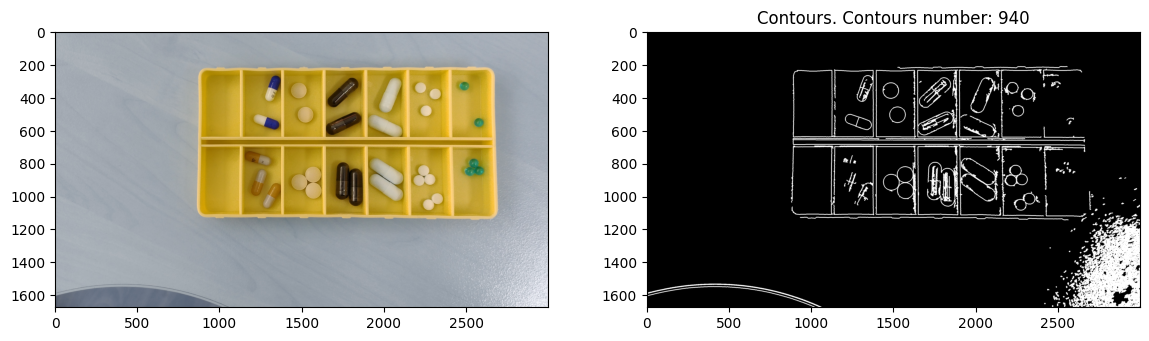

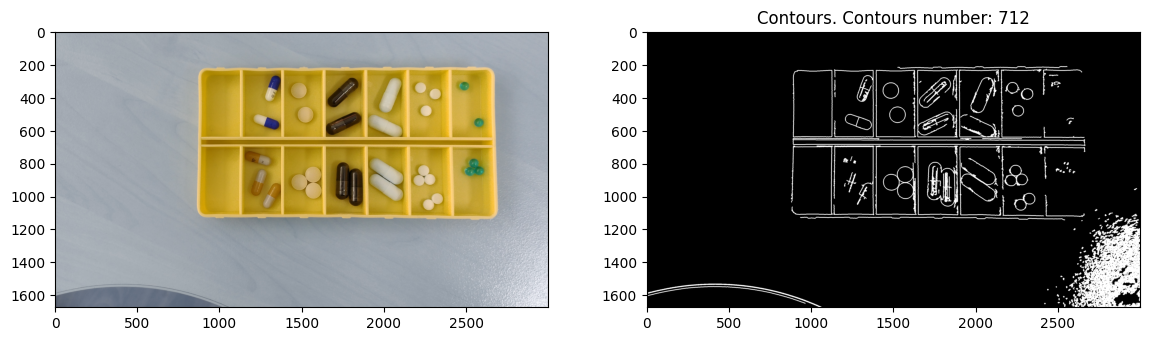

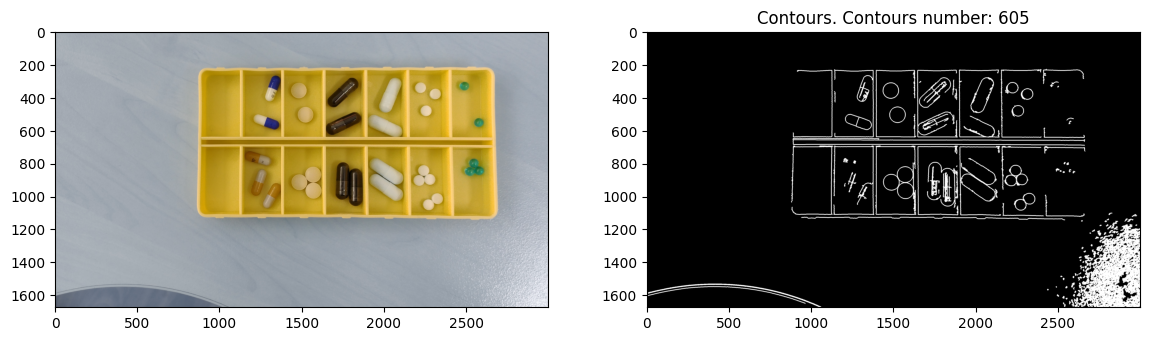

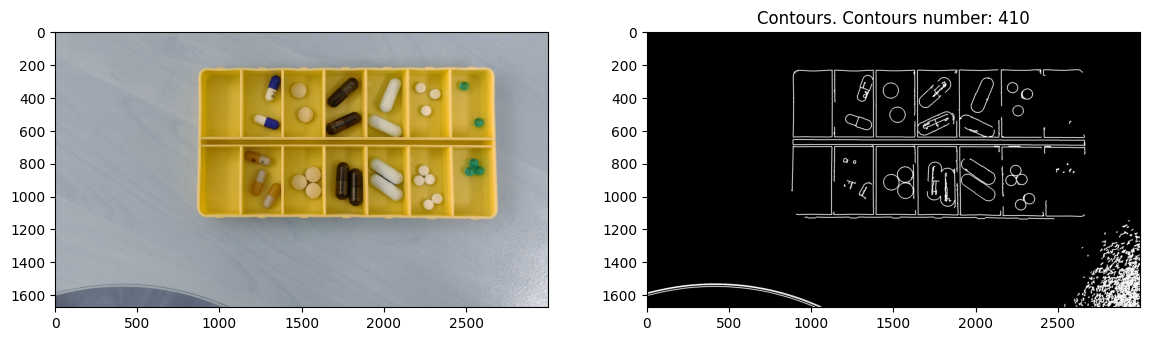

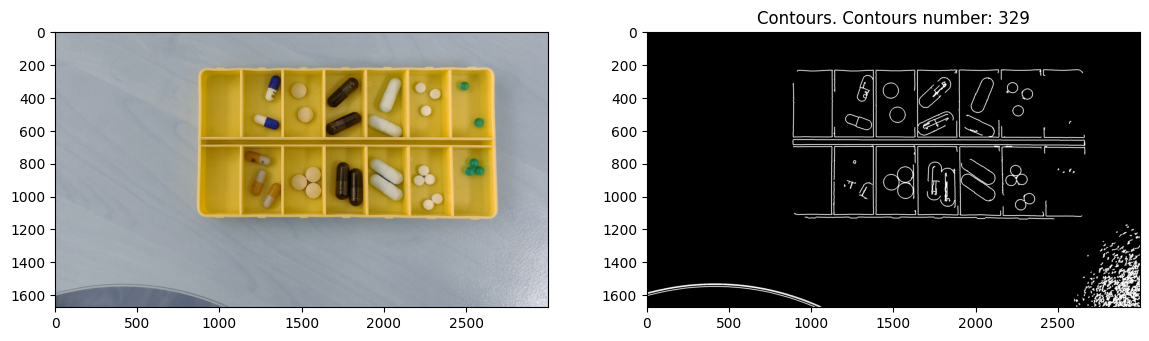

Liczba konturow:  329


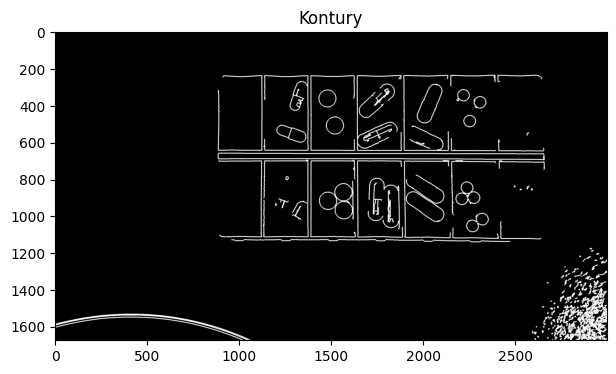

In [11]:
filter_matrix = np.array([[1, -1, 1], 
        [-1, 9, -1], 
        [1, -1, 1]])
filter_matrix = filter_matrix/filter_matrix.sum() 

filter_matrix_2 = np.array([[1, 2, 1], 
        [2, 4, 2], 
        [1, 2, 1]])
filter_matrix_2 = filter_matrix/filter_matrix.sum() 

kernel = np.ones((3, 3), dtype=np.uint8)

contours = detect_objects_configurable(calib,
    trans_sharp1=lambda x: cv2.filter2D(x, -1, filter_matrix),
    trans_sharp2=lambda x: cv2.filter2D(x, -1, filter_matrix),
    trans_eroded=lambda x: cv2.erode(x, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=1),
#   trans_morph=lambda x: morphology(x),
#   trans_morfo3=lambda x: morfologia(x),
    #trans_wyostrzyj3=lambda x: cv2.filter2D(x, -1, filter_matrix),
    #trans_hsv=lambda x: hsv_transform(x, threshold_h=-1, threshold_s=115, threshold_v=128),
    #trans_eroded=lambda x: cv2.erode(x, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=3),
    #trans_gray_lab=lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2LAB)[..., 1],
    trans_sharp3=lambda x: cv2.filter2D(x, -1, filter_matrix),
    #transdsdsd=lambda x: cv2.adaptiveThreshold(x, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 7),
    #
    #trans01=lambda x: cv2.filter2D(x, -1, filter_matrix),
    #trans_hsv=lambda x: hsv_transform(x, threshold_h=-1, threshold_s=-1, threshold_v=-1),
    #trans_bilateral=lambda x: cv2.bilateralFilter(x, 9, 65, 75),
    #trans_median_blur=lambda x: cv2.medianBlur(x, 7), 
    #trans_otsu=lambda x: sliding_window_otsu(x, 100),
    #trans_adaptive=lambda x: cv2.adaptiveThreshold(x, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 7, 2),
    contours_transformation={
        'gray': lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2GRAY),
        'threshold': lambda x: cv2.Canny(image=x, threshold1=50, threshold2=180)},
    contours_args=default_contours_args,
    plot_with_contours=True
    #max_contours_area=400,
)

In [14]:
kernel = np.ones((3, 3), dtype=np.uint8)

In [15]:
def hsv_transform(image, threshold_h=20, threshold_s=160, threshold_v=110):
    img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(img_hsv)

    if threshold_h != -1:
        (T, result_h) = cv2.threshold(h, threshold_h, 255, cv2.THRESH_BINARY_INV)
    else:
        result_h = h
    if threshold_s != -1:
        (T, result_s) = cv2.threshold(s, threshold_s, 255, cv2.THRESH_BINARY_INV)
    else:
        result_s = s
    #(T, result_v) = cv2.threshold(v, 120, 255, cv2.THRESH_BINARY_INV)
    if threshold_v != -1:
        (T, result_v) = cv2.threshold(v, threshold_v, 255, cv2.THRESH_BINARY_INV)
    else:
        result_v = v

    result = cv2.merge([result_h, result_s, result_v])
    return result

#transformed = hsv_transform(calib[y1:y2, x1:x2])
#transformed = cv2.cvtColor(transformed, cv2.COLOR_BGR2GRAY)#[..., 1], #
#plt.imshow(transformed)

In [16]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


def detect_objects_hehe(filename, erode_iterations, threshold_h, threshold_s, threshold_v, binarizer_selector, canny_threshold1, canny_threshold2):
    img = cv2.imread(filename)

    # stacked = []
    # for i in range(3):
    #     stacked.append(cv2.equalizeHist(box[..., i]))
    #     equ = np.stack(stacked[::-1], axis=2)
    # img = equ


    img = cv2.erode(img, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=erode_iterations)
    # img = hsv_transform(img, threshold_h=threshold_h, threshold_s=threshold_s, threshold_v=threshold_v)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if binarizer_selector == 'canny':
        img = cv2.Canny(img, threshold1=canny_threshold1, threshold2=canny_threshold2)
    elif binarizer_selector == 'sobel':
        img = cv2.Sobel(img, ddepth=cv2.CV_8U, dx=1, dy=1, ksize=canny_threshold1)
    elif binarizer_selector == 'adaptive':
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, canny_threshold1, canny_threshold2),
    plot_img(img, '')

    contours, hierarchy = cv2.findContours(img, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    display = np.zeros_like(img)
    cv2.drawContours(display, contours, -1, (255, 255, 0), 3)
    plot_img(display, 'Kontury')
    
    #return contours


interact(detect_objects_hehe,
            filename=widgets.Dropdown(options=['Data/calib.png', 'Data/test1.png', 'Data/test2.png', 'Data/test3.png']),
            erode_iterations=widgets.IntSlider(min=0, max=50, step=1, value=1),
            threshold_h=widgets.IntSlider(min=1, max=250, step=1, value=20),
            threshold_s=widgets.IntSlider(min=1, max=200, step=1, value=100),
            threshold_v=widgets.IntSlider(min=1, max=200, step=1, value=100),
            binarizer_selector=widgets.Dropdown(options=['canny', 'sobel', 'adaptive']),
            canny_threshold1=widgets.IntSlider(min=0, max=500, step=1, value=1),
            canny_threshold2=widgets.IntSlider(min=0, max=500, step=1, value=255),
        );


interactive(children=(Dropdown(description='filename', options=('Data/calib.png', 'Data/test1.png', 'Data/test…

In [17]:
def rhotheta2xy(line):
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 5000*(-b))
    y1 = int(y0 + 5000*(a))
    x2 = int(x0 - 5000*(-b))
    y2 = int(y0 - 5000*(a))
    return x1, y1, x2, y2

def get_hough_lines(img, canny_threshold1, canny_threshold2, hl_rho, hl_theta, hl_threshold, show):
    img_filtered = cv2.medianBlur(img, 13)
    canny_img = cv2.Canny(image=img_filtered, threshold1=canny_threshold1, threshold2=canny_threshold2)
    lines = cv2.HoughLines(canny_img, rho=hl_rho, theta=hl_theta, threshold=hl_threshold)

    img_to_show = img.copy()
    
    if show:
        for line in lines:
            x1, y1, x2, y2 = rhotheta2xy(line)
            cv2.line(img_to_show, (x1,y1), (x2,y2), (255,0,0), 2)
        plt.imshow(img_to_show)
        plt.show()
    return lines

hough_lines = get_hough_lines(calib, 
    canny_threshold1=40, 
    canny_threshold2=120, 
    hl_rho=3, 
    hl_theta=0.5*(np.pi/180), 
    hl_threshold=550,
    show=False)

In [18]:
print(hough_lines.shape)
hough_lines = np.reshape(hough_lines, (-1, 2))
print(hough_lines.shape)

(30, 1, 2)
(30, 2)


In [19]:
lines_angles = [np.pi/2 + line[1] for line in hough_lines]

In [20]:
pi_diff = np.pi/18
lines_horizontal = [line for i, line in enumerate(hough_lines) if -pi_diff < abs(lines_angles[i]) < pi_diff or np.pi - pi_diff < abs(lines_angles[i]) < np.pi + pi_diff ]
lines_vertical = [line for i, line in enumerate(hough_lines) if (np.pi/2) - pi_diff < abs(lines_angles[i]) < (np.pi/2) + pi_diff or (3 * np.pi/2) - pi_diff < abs(lines_angles[i]) <  (3 * np.pi/2) + pi_diff ]

In [21]:
lines_horizontal

[array([685.5      ,   1.5707964], dtype=float32),
 array([640.5      ,   1.5707964], dtype=float32),
 array([658.5      ,   1.5707964], dtype=float32),
 array([700.5      ,   1.5707964], dtype=float32),
 array([1096.5     ,    1.579523], dtype=float32),
 array([238.5      ,   1.5707964], dtype=float32),
 array([1114.5     ,    1.579523], dtype=float32),
 array([682.5     ,   1.579523], dtype=float32),
 array([220.5      ,   1.5707964], dtype=float32),
 array([1129.5      ,    1.5707964], dtype=float32),
 array([667.5     ,   1.579523], dtype=float32),
 array([1108.5      ,    1.5707964], dtype=float32),
 array([709.5      ,   1.5620697], dtype=float32),
 array([253.5      ,   1.5620697], dtype=float32),
 array([622.5     ,   1.579523], dtype=float32),
 array([1141.5      ,    1.5620697], dtype=float32)]

In [22]:
lines_vertical

[array([1390.5,    0. ], dtype=float32),
 array([1372.5,    0. ], dtype=float32),
 array([-1876.5     ,     3.132866], dtype=float32),
 array([-2146.5      ,     3.1241393], dtype=float32),
 array([1.144500e+03, 8.726646e-03], dtype=float32),
 array([-1621.5     ,     3.132866], dtype=float32),
 array([-2653.5     ,     3.106686], dtype=float32),
 array([1.126500e+03, 8.726646e-03], dtype=float32),
 array([-1894.5     ,     3.132866], dtype=float32),
 array([8.9850000e+02, 1.7453292e-02], dtype=float32),
 array([-2632.5     ,     3.106686], dtype=float32),
 array([-2404.5      ,     3.1241393], dtype=float32),
 array([-1639.5     ,     3.132866], dtype=float32),
 array([1624.5,    0. ], dtype=float32)]

In [23]:
# lines_img = calib.copy()
# for line in lines_vertical:
#     x1, y1, x2, y2 = rhotheta2xy(line)
#     cv2.line(lines_img, (x1,y1), (x2,y2), (255,0,0), 2)
# plt.imshow(lines_img)
# plt.show()

In [24]:
# lines_img = calib.copy()
# for line in lines_horizontal:
#     x1, y1, x2, y2 = rhotheta2xy(line)
#     cv2.line(lines_img, (x1,y1), (x2,y2), (255,0,0), 2)
# plt.imshow(lines_img)
# plt.show()

In [25]:
# https://stackoverflow.com/questions/46565975/find-intersection-point-of-two-lines-drawn-using-houghlines-opencv
def hough_intersection(theta1, rho1, theta2, rho2):
    A = np.array([[np.cos(theta1), np.sin(theta1)], 
                  [np.cos(theta2), np.sin(theta2)]])
    b = np.array([rho1, rho2])
    return np.linalg.lstsq(A, b)[0]

/tmp/ipykernel_24290/2730280017.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(A, b)[0]


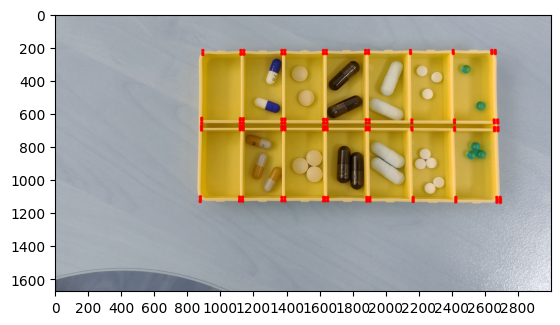

In [26]:
boxes_crosses = []
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

lines_img = calib.copy()
for (rho_1, theta_1) in lines_vertical:
    for (rho_2, theta_2) in lines_horizontal:
        if (rho_1, theta_1) != (rho_2, theta_2):
            x, y = hough_intersection(theta_1, rho_1, theta_2, rho_2)
            boxes_crosses.append((x, y))
            if 0 < x < calib.shape[1] and 0 < y < calib.shape[0]:
                lines_img = cv2.circle(lines_img, (int(x), int(y)), radius=10, color=(255, 0, 0), thickness=-1)

major_ticks_x = np.arange(0, calib.shape[1], 200)
major_ticks_y = np.arange(0, calib.shape[0], 200)
ax.set_xticks(major_ticks_x)
ax.set_yticks(major_ticks_y)
ax.imshow(lines_img)

In [ ]:
box_approx_width = 300
box_approx_height = 450
boxes_rectangles = []

lines_img = calib.copy()
for (x1, y1) in boxes_crosses:
    for (x2, y2) in boxes_crosses:
        if (x1, y1) != (x2, y2):
            box_width = x2 - x1
            box_height = y2 - y1
            if abs(box_width - box_approx_width) < 70 and abs(box_height - box_approx_height) < 70:
                lines_img = cv2.rectangle(lines_img, (int(x1), int(y1)), (int(x2), int(y2)), color=(255, 0, 0), thickness=2)
                boxes_rectangles.append([int(x1), int(y1), int(x2), int(y2)])

plt.imshow(lines_img)

In [14]:
# from nms import non_max_suppression_fast

# boxes_rectangles_filtered = non_max_suppression_fast(np.array(boxes_rectangles), overlapThresh=0.3)
# boxes_rectangles_filtered = sorted(boxes_rectangles_filtered, key=lambda x: x[0])

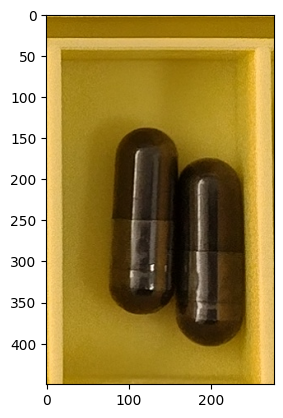

In [15]:
for x1, y1, x2, y2 in boxes_rectangles[660:661]: # TODO: filtered
    plt.imshow(calib[y1:y2, x1:x2])
    plt.show()
    break

In [18]:
def sliding_window_otsu(image, window_size):
    img = image.copy()
    step = window_size
    for i in range(0, img.shape[0], step):
        for j in range(0, img.shape[1], step):
            slice = img[i:(i + window_size), j:(j + window_size)]
            (T, transformed) = cv2.threshold(slice, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            img[i:(i + window_size), j:(j + window_size)] = transformed
    
    return img

In [19]:
COLORS = [
  (255, 0, 0),
  (0, 255, 0),
  (0, 0, 255),
  (255, 255, 0),
  (255, 0, 255),
  (0, 255, 255),
]

def display_objects(image:np.ndarray, objects:List) -> None:
  image = image.copy()

  cv2.drawContours(image, objects, -1, (255, 0, 0), 3)
  plt.imshow(image)

In [20]:
def ret_img(x):
    return x

In [22]:
def find_box(img: np.ndarray) -> np.ndarray:
    hue = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[..., 0]

    # threshold
    _, binary = cv2.threshold(hue, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # find bounding rectangle for each contour
    rects = [cv2.boundingRect(c) for c in contours]

    # get biggest rectangle
    rect = max(rects, key=lambda r: r[2] * r[3])

    # crop image
    return img[rect[1]:rect[1] + rect[3], rect[0]:rect[0] + rect[2]]  # shouldnt i use mask?

box = find_box(calib)

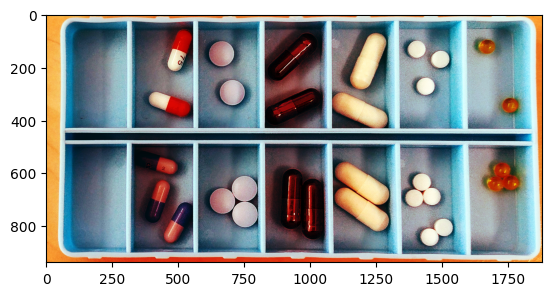

In [24]:
#   pills_box = box[y:y+h, x:x+w]
  
stacked = []
for i in range(3):
    stacked.append(cv2.equalizeHist(box[..., i]))
    equ = np.stack(stacked[::-1], axis=2)
plt.imshow(equ)

interactive(children=(Dropdown(description='filename', options=('Data/calib.png', 'Data/test1.png', 'Data/test…

In [27]:
filter_matrix = np.array([[1, -1, 1], 
        [-1, 9, -1], 
        [1, -1, 1]])
filter_matrix = filter_matrix/filter_matrix.sum() 

### Zadanie 2
Dodaj do pipeline'u przetwarzania algorytm analizy obiektów, pozwalający na rozróżnienie obiektów poszczególnych klas.
Podejście jest zupełnie dowolne:
możesz zaimplementować go jako osobną procedurę (post-processing uzyskanych konturów) opartą o analizę kształtu i barwy,
możesz próbować zintegrować go z detekcją obiektów.
Obowiązuje tylko jedno zastrzeżenie: algorytm powinien być "klasyczny", tj. bez użycia uczenia maszynowego.

Jakkolwiek zdecydujesz, wyjściem algorytmu powinny być poetykietowane obiekty (kontur/bbox + etykieta).
Dodaj implementację funkcji `display_recognized` do rysowania wykrytych instancji;
skorzystaj z podanej mapy kolorów.

_Pro-tip do podejścia z post-processingiem konturów: zapoznaj się z metodami [zaawansowanego indeksowania macierzy](https://numpy.org/doc/stable/user/basics.indexing.html#advanced-indexing) w numpy, zwłaszcza indeksowaniem za pomocą macierzy binarnej. TL;DR: `obraz[maska]` powoduje odwołanie się tylko do tych pikseli obrazu `obraz`, które odpowiadają położeniem niezerowym pikselom maski._

In [28]:
COLORMAP = {
  'keto': (0, 0, 255), # RGB
  'carbon': (0, 0, 0),
  'probio': (255, 255, 255),
  'biox': (255, 0, 255),
  'espu': (255, 255, 0),
  'line': (255, 0, 0),
  'dexi': (127, 127, 127)
}

def display_recognized(image:np.ndarray, objects:List) -> None:
  raise NotImplementedError

In [29]:
found = detect_objects(calib)
#...
display_recognized(calib, found)

NameError: name 'detect_objects' is not defined

### Zadanie 3

Przetestuj uzyskany algorytm na obrazach `test1.png`, `test2.png` i `test3.png`.
Gdzie pojawiają się problemy, skąd się biorą?
Jak można im zaradzić?

In [ ]:
images = ['test1', 'test2', 'test3']
fig, ax = plt.subplots(1, len(images), figsize=(16,9))
for i, img_name in enumerate(images):
    test_img = cv2.imread(f'Data/{img_name}.png')
    ax[i].imshow(test_img[..., ::-1])

In [ ]:
# miejsce na test - pozostaw wyniki działania oryginalnego algorytmu

In [ ]:
# miejsce na poprawki algorytmu

### Zadanie 4

Wykorzystaj transformację Hougha do wykrycia linii oddzielających poszczególne komórki organizera.
Dowolną poznaną metodą oblicz środki wykrytych obiektów.
Połącz obie informacje by określić zawartość każdej z komórek.

Wynik tej operacji powinien mieć formę struktury logicznej, pozwalającej na odpowiadanie na pytania np. "czy w 3 komórce dolnego rzędu są dwie sztuki `biox`?";
szczegóły układu tej struktury są dowolne.

Jak poprzednio, zacznij od obrazu `calib`, a gotowy algorytm przetestuj na obrazach testowych.

In [ ]:
#Detekcja krawędzi metodą Canny'ego - wynik zależy od doboru wartości progów:
img_gray = cv2.cvtColor(calib, cv2.COLOR_BGR2GRAY)
img_canny = cv2.Canny(image=img_gray, threshold1=60, threshold2=120)
Image.fromarray(img_canny)

def rhotheta2xy(line):
    # to samo co w przykładzie tylko w formie funkcji - na potrzeby rysowania
    # zwraca współrzędne odcinka leżącego na pojedynczej linii
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 5000*(-b))
    y1 = int(y0 + 5000*(a))
    x2 = int(x0 - 5000*(-b))
    y2 = int(y0 - 5000*(a))
    return x1, y1, x2, y2

lines = cv2.HoughLines(img_canny, rho=1, theta=np.pi/180, threshold=750)
image_lines = calib.copy()
#Aby narysować wyniki, przechodzimy ze współrzędnych rho-theta na XY
for line in lines:
    x1, y1, x2, y2 = rhotheta2xy(line)
    cv2.line(image_lines, (x1,y1), (x2,y2), (255,0,0), 2)

plt.imshow(image_lines)#Image.fromarray(image_lines)
plt.axis('off')
plt.show()
#ax[i][j].set_title(f'rho: {rho}. threshold: {threshold}')